In [228]:
library(tidyverse)
library(gridExtra)
library(ape)
library(cowplot)
library(gridGraphics)
library(readr)
library(utils)

#### Load and re-order the first dataset

In [229]:
tmp_windows <- read.delim('numbered_10kbtreepaths.txt', header = F, row.names = 1)

In [230]:
colnames(tmp_windows) = "pathname"
windows_and_weights <- tmp_windows %>%
  rowwise() %>%
  mutate(scaffold = str_split(pathname, "_")[[1]][[1]]) %>%
  mutate(start = as.numeric(str_split(str_split(pathname, "bp_")[[1]][2], "-")[[1]][1])) %>%
  mutate(end = as.numeric(str_split(str_split(pathname, "-")[[1]][2], ".fa")[[1]][1])) %>%
  mutate(mid = ceiling(mean(c(start, end)))) %>%
  mutate(sites = end-start+1) %>%
  mutate(lnL = NA) %>%
  ungroup() %>%
  mutate(treenumber = row_number()) %>%
  select(-pathname)

In [231]:
#set up initial weights file and add to windows_and_weights
#toponumber = the number of topologies at the beginning of the weights file
toponumber = 3
tmp_weights <- read.delim("laevis_eatonii_barbatus.weights.txt.gz",
                          sep = '\t', skip = toponumber)
windows_and_weights <- cbind(windows_and_weights, tmp_weights)

In [232]:
#now, reorder first by scaffold, then by start column
windows_and_weights <- arrange(windows_and_weights, scaffold, start)

In [233]:
#first, windows:
newwindow <- windows_and_weights[,1:6]

In [234]:
#write windows file
con <- gzfile("REORDERED_WINDOWS_10kbtrees.tsv.gz", "w")
write.table(as.data.frame(newwindow), con,
            sep = '\t', quote = F, row.names = F)
close(con)

In [235]:
#next, the weights (and header for the weights file):
#starts at col 8 and continues to the end of the table
newweights <- windows_and_weights[,8:ncol(windows_and_weights)]
weightsheader <- as.data.frame(readLines("laevis_eatonii_barbatus.weights.txt.gz",
                                         n = toponumber))

con <- gzfile("REORDERED_WEIGHTS_laevis_eatonii_barbatus.tsv.gz", "w")
write.table(as.data.frame(weightsheader), con,
            quote = F, row.names = F, col.names = F)
write.table(as.data.frame(newweights), con,
            sep = '\t', quote = F, row.names = F)
close(con)

#### Load and re-order the second dataset

In [236]:
tmp_windows <- read.delim('numbered_10kbtreepaths.txt', header = F, row.names = 1)

colnames(tmp_windows) = "pathname"
windows_and_weights <- tmp_windows %>%
  rowwise() %>%
  mutate(scaffold = str_split(pathname, "_")[[1]][[1]]) %>%
  mutate(start = as.numeric(str_split(str_split(pathname, "bp_")[[1]][2], "-")[[1]][1])) %>%
  mutate(end = as.numeric(str_split(str_split(pathname, "-")[[1]][2], ".fa")[[1]][1])) %>%
  mutate(mid = ceiling(mean(c(start, end)))) %>%
  mutate(sites = end-start+1) %>%
  mutate(lnL = NA) %>%
  ungroup() %>%
  mutate(treenumber = row_number()) %>%
  select(-pathname)
  
#set up initial weights file and add to windows_and_weights
#toponumber = the number of topologies at the beginning of the weights file
toponumber = 3
tmp_weights <- read.delim("virgatus_barbatus_eatonii.weights.txt.gz",
                          sep = '\t', skip = toponumber)
windows_and_weights <- cbind(windows_and_weights, tmp_weights)

#now, reorder first by scaffold, then by start column
windows_and_weights <- arrange(windows_and_weights, scaffold, start)

#first, windows:
newwindow <- windows_and_weights[,1:6]

#write windows file
con <- gzfile("REORDERED_WINDOWS_10kbtrees.tsv.gz", "w")
write.table(as.data.frame(newwindow), con,
            sep = '\t', quote = F, row.names = F)
close(con)

#next, the weights (and header for the weights file):
#starts at col 8 and continues to the end of the table
newweights <- windows_and_weights[,8:ncol(windows_and_weights)]
weightsheader <- as.data.frame(readLines("virgatus_barbatus_eatonii.weights.txt.gz",
                                         n = toponumber))

con <- gzfile("REORDERED_WEIGHTS_virgatus_barbatus_eatonii.tsv.gz", "w")
write.table(as.data.frame(weightsheader), con,
            quote = F, row.names = F, col.names = F)
write.table(as.data.frame(newweights), con,
            sep = '\t', quote = F, row.names = F)
close(con)

#### Plotting the results

In [237]:
#call in the twisst plotting functions provided by devs
source("/home/lcwheeler/Downloads/twisst/plot_twisst.R")

#window data file
window_data_file <- "REORDERED_WINDOWS_10kbtrees.tsv.gz"

#info for test 1 and test 2 weights
weights_file1 <- "REORDERED_WEIGHTS_laevis_eatonii_barbatus.tsv.gz"
weights_file2 <- "REORDERED_WEIGHTS_virgatus_barbatus_eatonii.tsv.gz"


In [238]:
#generate twisst data frames
twisst_data1 <- import.twisst(weights_files=weights_file1,
                             window_data_files=window_data_file)

twisst_data2 <- import.twisst(weights_files=weights_file2,
                              window_data_files=window_data_file)

[1] "Reading weights and window data"
[1] "Number of regions: 11"
[1] "Computing summaries"
[1] "Cleaning data"
[1] "Getting topologies"
[1] "Reading weights and window data"
[1] "Number of regions: 11"
[1] "Computing summaries"
[1] "Cleaning data"
[1] "Getting topologies"


In [239]:
#generate list for good scaffolds
scaflist <- names(twisst_data1$lengths)
scaflist <- scaflist[scaflist %in% 
                       c("LG01", "LG02", "LG03", "LG04", "LG05", "LG06", "LG07", "LG08")]

In [240]:
scaflist

[1] "LG01" "LG02" "LG03" "LG04" "LG05" "LG06" "LG07" "LG08"

In [241]:
#set up new df to append to and eventually plot
newdf <- data.frame()

#set up test 1 df in the newdf
for (i in 1:length(scaflist)){
  twisst_subdata <- subset.twisst.by.regions(twisst_data1, scaflist[i])
  twisst_data_smooth <- smooth.twisst(twisst_subdata, span_bp = 2000000, spacing = 5000)
  
  #make new df
  tmpdf <- as.data.frame(twisst_data_smooth$pos); colnames(tmpdf)[1] <- "pos"
  tmpdf$chromosome <- scaflist[i]
  tmpdf$testno <- "test1"
  tmpdf <- cbind(tmpdf, as.data.frame(twisst_data_smooth$weights))
  
  
  #bind to newdf
  newdf <- rbind(newdf, tmpdf)
}

[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"


In [242]:
#and now add the test 2 information so we can plot all together
for (i in 1:length(scaflist)){
  twisst_subdata <- subset.twisst.by.regions(twisst_data2, scaflist[i])
  twisst_data_smooth <- smooth.twisst(twisst_subdata, span_bp = 2000000, spacing = 5000)
  
  #make new df
  tmpdf <- as.data.frame(twisst_data_smooth$pos); colnames(tmpdf)[1] <- "pos"
  tmpdf$chromosome <- scaflist[i]
  tmpdf$testno <- "test2"
  tmpdf <- cbind(tmpdf, as.data.frame(twisst_data_smooth$weights))
  
  
  #bind to newdf
  newdf <- rbind(newdf, tmpdf)
}

[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"
[1] "smoothing topo1"
[1] "smoothing topo2"
[1] "smoothing topo3"


In [243]:
newdf

,pos,chromosome,testno,topo1,topo2,topo3
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,5001,LG01,test1,0.9668818,0.012701667,0.020416498
2,10001,LG01,test1,0.9680176,0.012250967,0.019731475
3,15001,LG01,test1,0.9691271,0.011807190,0.019065714
4,20001,LG01,test1,0.9702106,0.011370344,0.018419102
5,25001,LG01,test1,0.9712680,0.010940437,0.017791525
6,30001,LG01,test1,0.9722997,0.010517475,0.017182869
7,35001,LG01,test1,0.9733055,0.010101466,0.016593020
8,40001,LG01,test1,0.9742857,0.009692419,0.016021866
9,45001,LG01,test1,0.9752404,0.009290339,0.015469291


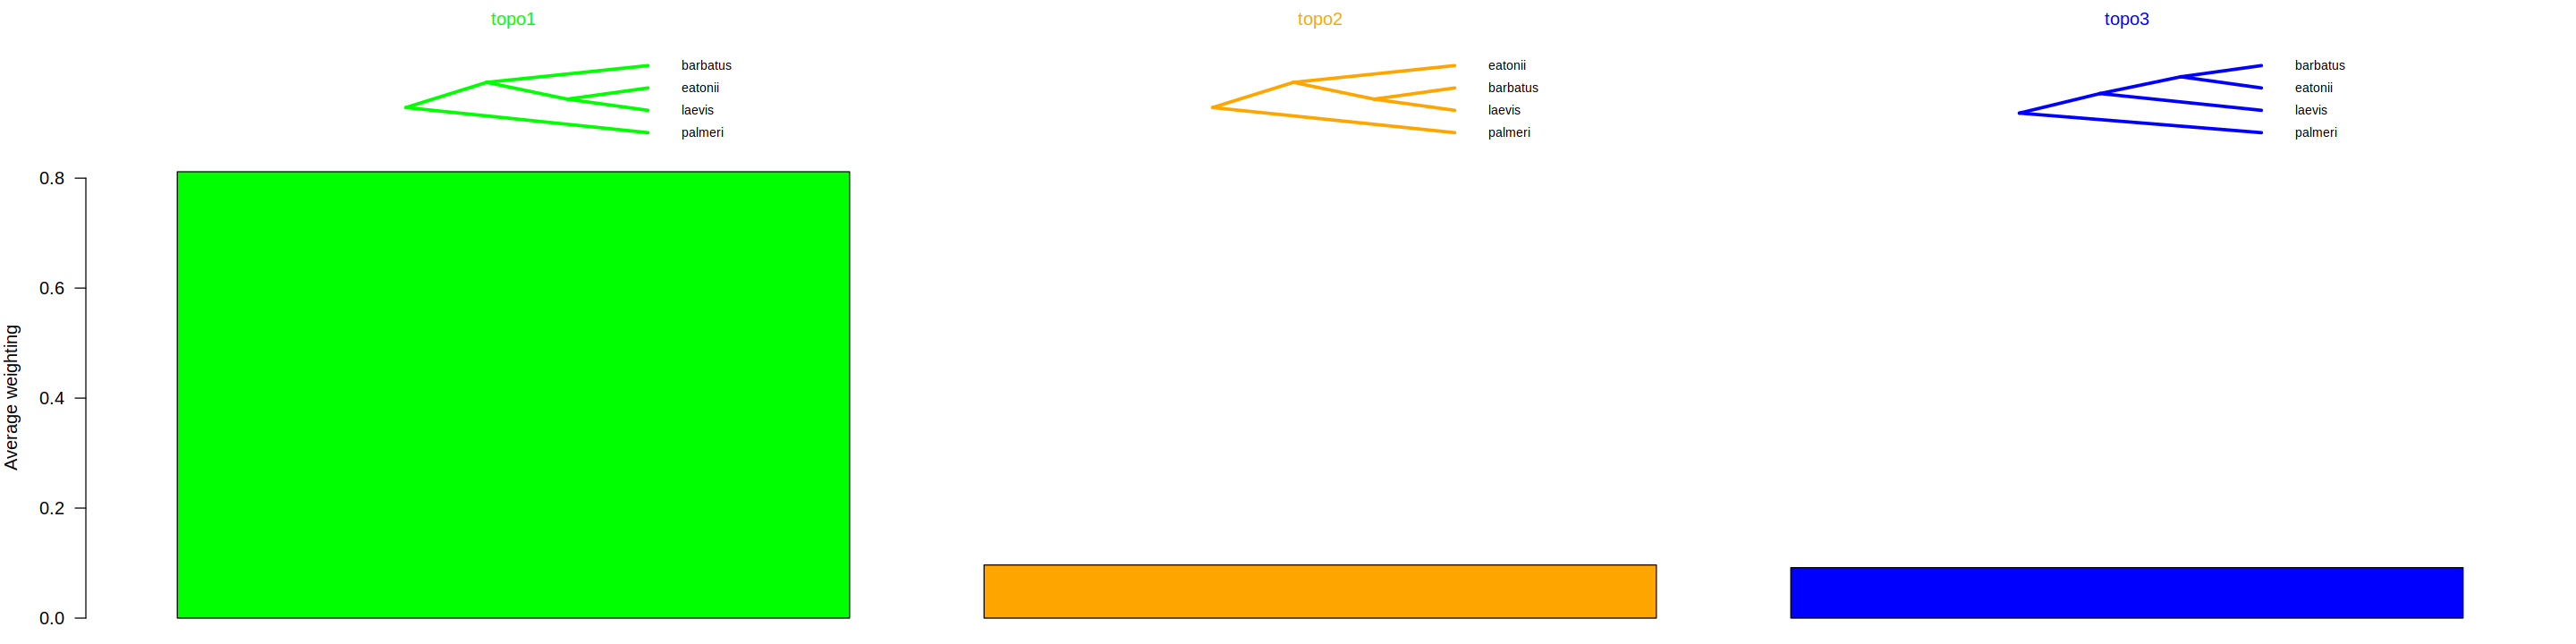

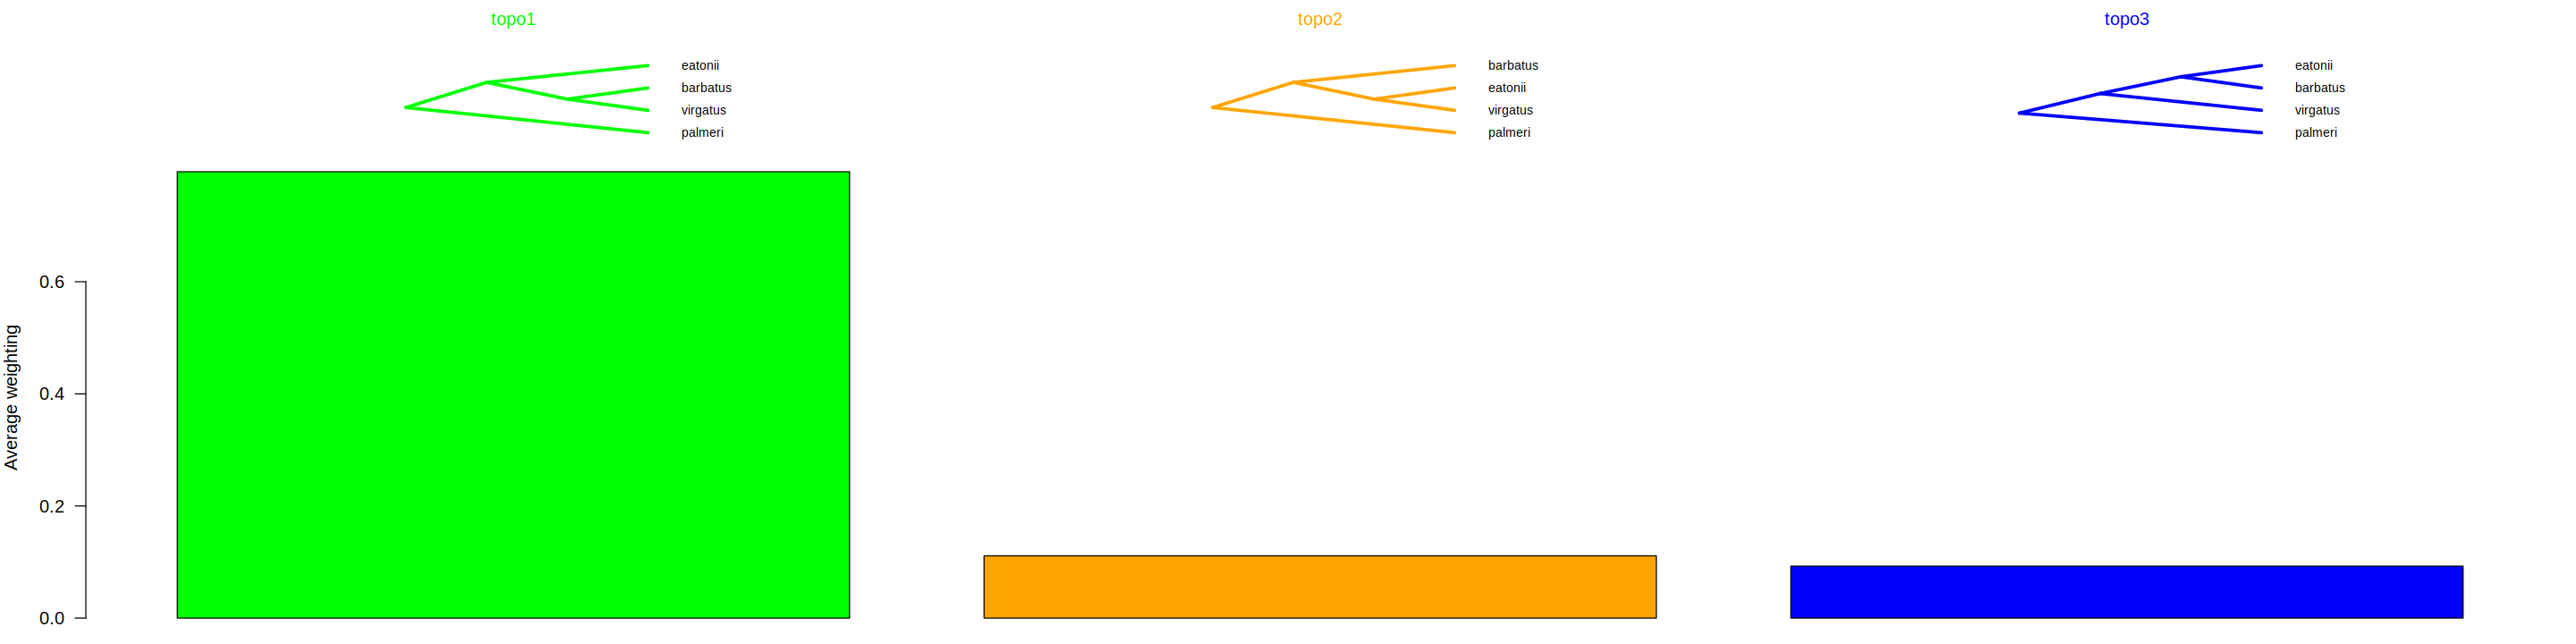

In [244]:

#generate plots of each topo and average weightings for the two tests
t1 <- subset.twisst.by.regions(twisst_data1, scaflist)
plot.twisst.summary(t1, cols = c("green", "orange", "blue"), lwd=3, cex=0.7)
a <- recordPlot()

t2 <- subset.twisst.by.regions(twisst_data2, scaflist)
plot.twisst.summary(t2, cols = c("green", "orange", "blue"), lwd=3, cex=0.7)
b <- recordPlot()

In [245]:
#plot output, facet grid by chromosome and test
c <- ggplot(newdf, aes(x = pos/1000000)) +
  geom_ribbon(aes(y = topo1, ymin = 0, ymax = topo1), col = "green", fill = "green", alpha = 0.25) + 
  geom_ribbon(aes(y = topo2, ymin = 0, ymax = topo2), col = "orange", fill = "orange", alpha = 0.25) + 
  geom_ribbon(aes(y = topo3, ymin = 0, ymax = topo3), col = "blue", fill = "blue", alpha = 0.25) + 
  ylim(c(0,1)) +
  facet_grid(testno ~ chromosome,
             scales = "free_x", space = "free_x") +
  xlab("Position on scaffold (Mb)") +
  ylab("Weightings")


In [246]:
#generate plot
rightpanel <- plot_grid(a, b, ncol = 1, scale = c(0.8, 0.8))

pdf("barbatus_eatonii_tests.pdf", width = 40, height = 10)
plot_grid(c, rightpanel, ncol = 2, rel_widths = c(6,1), scale = c(0.95, 0.95))
dev.off()


png 
  2

### Examine peak overlap between tests

In [247]:
library(pracma)

In [248]:
signal <- copy(newdf)

In [249]:
signal["topo3_diff"] <- signal["topo3"] - signal["topo2"]

In [250]:
max(signal$topo3_diff)

[1] 0.3040403

In [251]:
min(signal$topo3_diff)

[1] -0.280088

In [252]:
signal

,pos,chromosome,testno,topo1,topo2,topo3,topo3_diff
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,5001,LG01,test1,0.9668818,0.012701667,0.020416498,0.007714831
2,10001,LG01,test1,0.9680176,0.012250967,0.019731475,0.007480508
3,15001,LG01,test1,0.9691271,0.011807190,0.019065714,0.007258524
4,20001,LG01,test1,0.9702106,0.011370344,0.018419102,0.007048758
5,25001,LG01,test1,0.9712680,0.010940437,0.017791525,0.006851088
6,30001,LG01,test1,0.9722997,0.010517475,0.017182869,0.006665394
7,35001,LG01,test1,0.9733055,0.010101466,0.016593020,0.006491554
8,40001,LG01,test1,0.9742857,0.009692419,0.016021866,0.006329447
9,45001,LG01,test1,0.9752404,0.009290339,0.015469291,0.006178952


##### Subset the transformed signal by test and then subtract test 2 topo3_diff from test 1

In [253]:
t1_signal <- signal[signal$testno %in% c("test1"),]
t2_signal <- signal[signal$testno %in% c("test2"),]

In [254]:
# This is the difference of differences: a lower value is equivalent to less difference in the topo1-topo2 diff between tests
t1_signal["test_diff_topo3"] = t1_signal$topo3_diff  - t2_signal$topo3_diff

##### Plot the transformed topo weighting signals

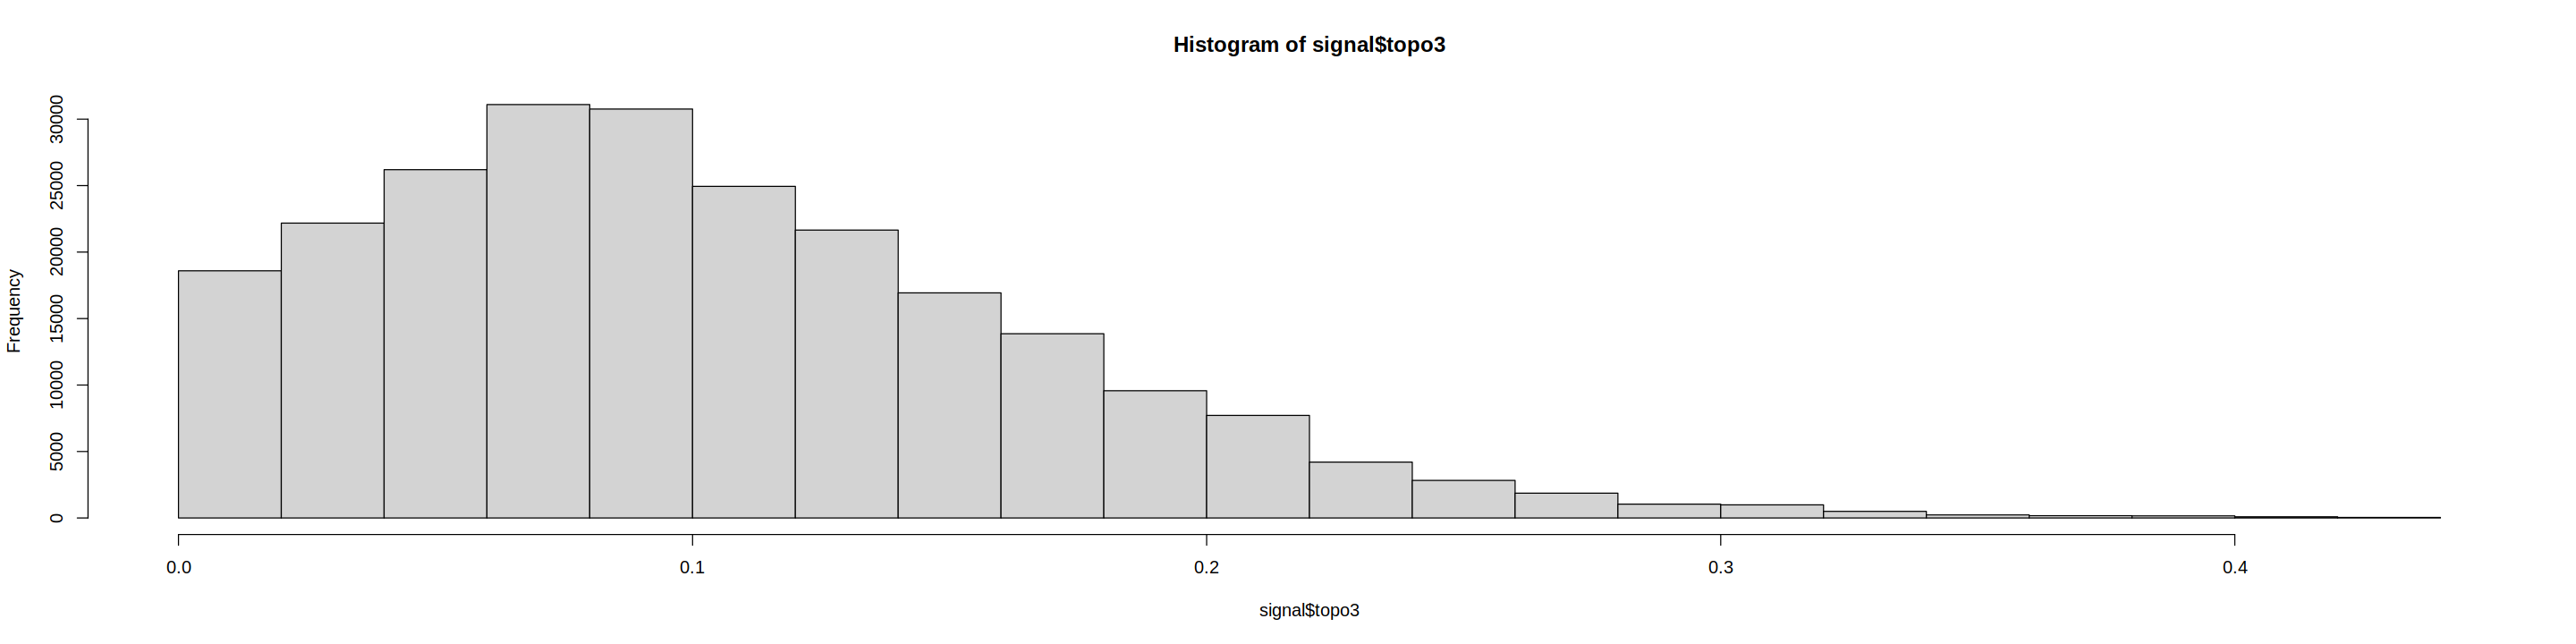

In [255]:
hist(signal$topo3)

In [256]:
#plot output, facet grid by chromosome and test
ct <- ggplot(signal, aes(x = pos/1000000)) +
  geom_line(aes(y = topo3_diff), col = "blue", alpha = 1) + 
  ylim(c(-0.5,0.5)) +
  facet_grid(testno ~ chromosome,
             scales = "free_x", space = "free_x") +
  xlab("Position on scaffold (Mb)") +
  ylab("Difference topo3-topo2 Weightings") #+
  #geom_point(aes(x=9188967, y=0), colour="blue")

#generate plot
rightpanel <- plot_grid(a, b, ncol = 1, scale = c(0.8, 0.8))

pdf("barbatus_eatonii_tests-2Mb-5kb-smoothing-diff.pdf", width = 40, height = 10)
plot_grid(ct, rightpanel, ncol = 2, rel_widths = c(6,1), scale = c(0.95, 0.95))
dev.off()

png 
  2

##### Overlay the significant CDS results and candidate gene values onto genomic window plots

In [257]:
cds_overlap = read.csv("/home/lcwheeler/Documents/WessingerLabPostdoc/research/Habroanthus/twisst_analyses/CDS_target_trios/overlap-peaks-eatonii-barbatus-coords.csv", sep=",")

In [258]:
print(mean(c(9188967,9191072))) #F3'5'H #LG01
print(mean(c(15285668,15291334))) #bHLH #LG01
print(mean(c(66244040,66248615))) #AP2 #LG04

[1] 9190020
[1] 15288501
[1] 66246328


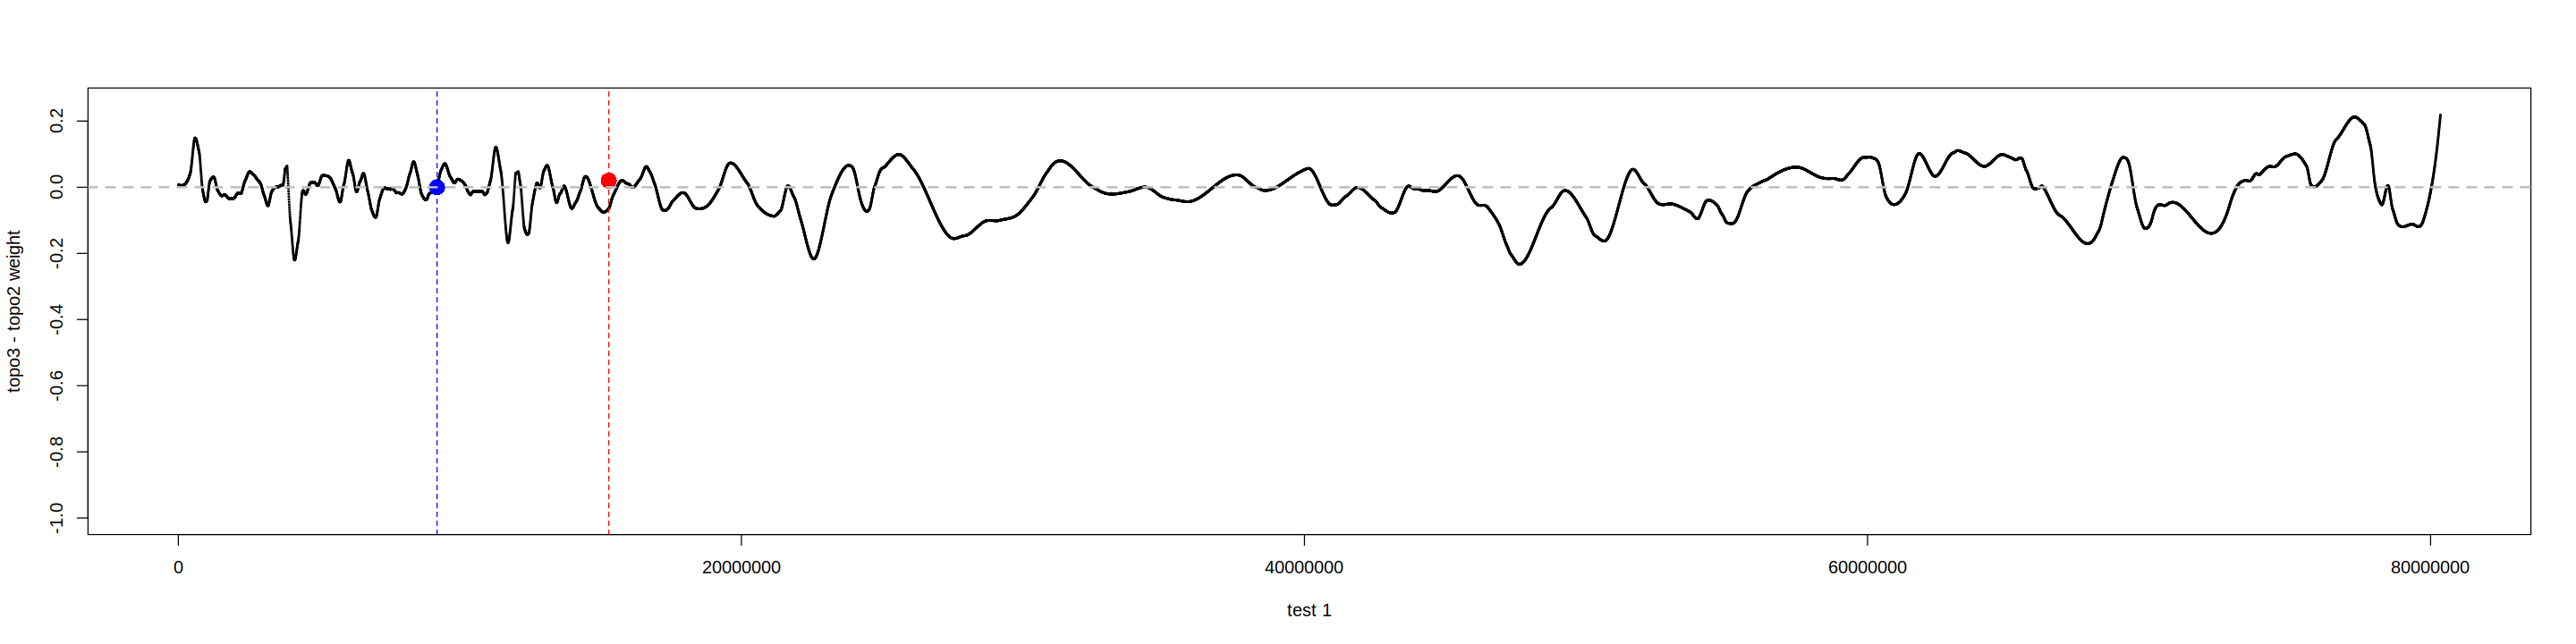

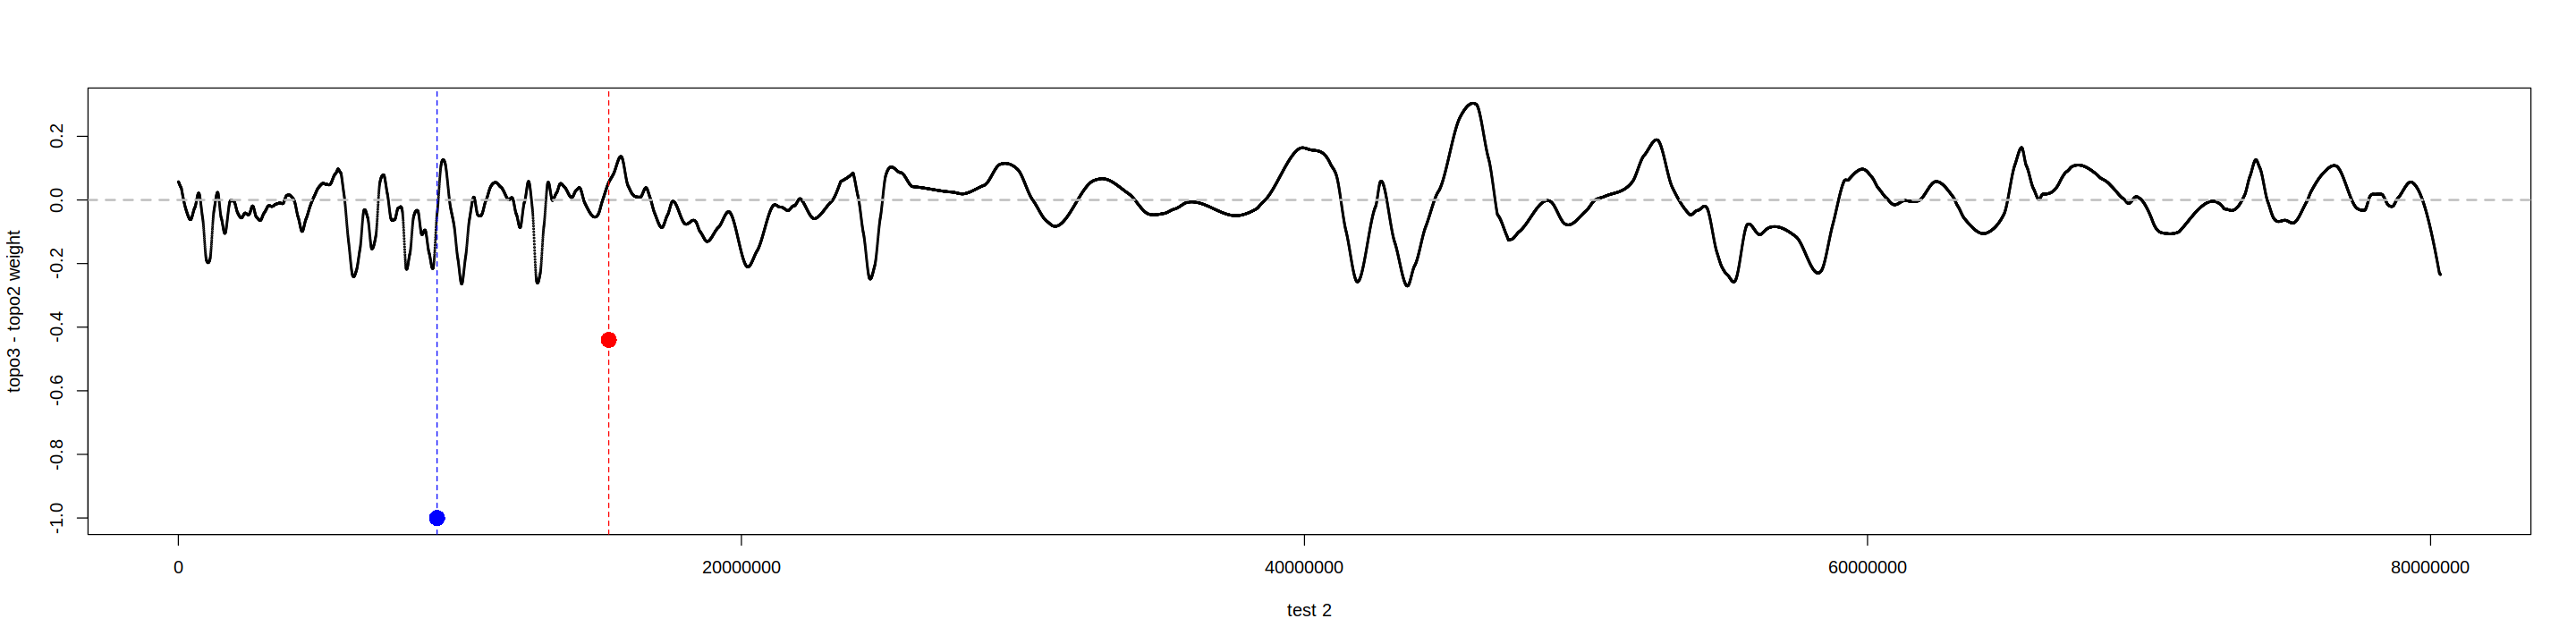

In [259]:
# Plot the difference signal for LG01 with the QTL candidate genes marked

#pdf(file="QTL-candidates-mapped-t3t2diff.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG01")$topo3_diff~subset(t1_signal, chromosome == "LG01")$pos, ylim=c(-1,0.25), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)
points(9190020, 0, col="blue", pch=16, cex=2)
points(15288501, 0.02, col="red", pch=16, cex=2)
abline(0, 0, col="gray", lty=2, lw=2)
abline(v=9190020, col="blue", lty=2)
abline(v=15288501, col="red", lty=2)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG01")$topo3_diff~subset(t2_signal, chromosome == "LG01")$pos, ylim=c(-1,0.3), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)
points(9190020, -1.0, col="blue", pch=16, cex=2)
points(15288501, -0.44, col="red", pch=16, cex=2)
abline(0, 0, col="gray", lty=2, lw=2)
abline(v=9190020, col="blue", lty=2)
abline(v=15288501, col="red", lty=2)

#dev.off()

In [260]:
head(cds_overlap)

,gene_id,topo1,topo2,topo3,gene_id.1,trio,tree_no,t3t2_diff,pos,chromosome
,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<chr>
1,Pbar_2022_maker4_04148-RA,0.18,0.00,0.82,Pbar_2022_maker4_04148-RA,virgatus_barbatus_eatonii,2420,0.82,811398,LG08
2,Pbar_2022_maker4_04526-RA,0.00,0.00,1.00,Pbar_2022_maker4_04526-RA,virgatus_barbatus_eatonii,2602,1.00,7692346,LG08
3,Pbar_2022_maker4_04711-RA,0.00,0.20,0.80,Pbar_2022_maker4_04711-RA,virgatus_barbatus_eatonii,2648,0.60,13410837,LG08
4,Pbar_2022_maker4_05019-RA,0.00,0.00,1.00,Pbar_2022_maker4_05019-RA,virgatus_barbatus_eatonii,2758,1.00,30759779,LG08
5,Pbar_2022_maker4_05018-RA,0.20,0.00,0.80,Pbar_2022_maker4_05018-RA,virgatus_barbatus_eatonii,2757,0.80,30747246,LG08
6,Pbar_2022_maker4_05915-RA,0.16,0.18,0.66,Pbar_2022_maker4_05915-RA,virgatus_barbatus_eatonii,2853,0.48,77628470,LG08


In [261]:
# Plot the difference signal for LG01 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG01.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG01")$topo3_diff~subset(t1_signal, chromosome == "LG01")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)
points(9190020, 0, col="blue", pch=16, cex=2)
points(15288501, 0.02, col="red", pch=16, cex=2)
points(subset(cds_overlap, chromosome == "LG01")$t3t2_diff~subset(cds_overlap, chromosome == "LG01")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG01")$topo3_diff~subset(t2_signal, chromosome == "LG01")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)
points(9190020, -1.0, col="blue", pch=16, cex=2)
points(15288501, -0.44, col="red", pch=16, cex=2)
points(subset(cds_overlap, chromosome == "LG01")$t3t2_diff~subset(cds_overlap, chromosome == "LG01")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [262]:
# Plot the difference signal for LG02 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG02.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG02")$topo3_diff~subset(t1_signal, chromosome == "LG02")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)

points(subset(cds_overlap, chromosome == "LG02")$t3t2_diff~subset(cds_overlap, chromosome == "LG02")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG02")$topo3_diff~subset(t2_signal, chromosome == "LG02")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)

points(subset(cds_overlap, chromosome == "LG02")$t3t2_diff~subset(cds_overlap, chromosome == "LG02")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [263]:
# Plot the difference signal for LG03 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG03.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG03")$topo3_diff~subset(t1_signal, chromosome == "LG03")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)

points(subset(cds_overlap, chromosome == "LG03")$t3t2_diff~subset(cds_overlap, chromosome == "LG03")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG03")$topo3_diff~subset(t2_signal, chromosome == "LG03")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)

points(subset(cds_overlap, chromosome == "LG03")$t3t2_diff~subset(cds_overlap, chromosome == "LG03")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [264]:
# Plot the difference signal for LG04 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG04.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG04")$topo3_diff~subset(t1_signal, chromosome == "LG04")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)
points(66246328, 0, col="magenta", pch=16, cex=2)
points(subset(cds_overlap, chromosome == "LG04")$t3t2_diff~subset(cds_overlap, chromosome == "LG04")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG04")$topo3_diff~subset(t2_signal, chromosome == "LG04")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)
points(66246328, -1.0, col="magenta", pch=16, cex=2)
points(subset(cds_overlap, chromosome == "LG04")$t3t2_diff~subset(cds_overlap, chromosome == "LG04")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [265]:
# Plot the difference signal for LG05 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG05.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG05")$topo3_diff~subset(t1_signal, chromosome == "LG05")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)

points(subset(cds_overlap, chromosome == "LG05")$t3t2_diff~subset(cds_overlap, chromosome == "LG05")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG05")$topo3_diff~subset(t2_signal, chromosome == "LG05")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)

points(subset(cds_overlap, chromosome == "LG05")$t3t2_diff~subset(cds_overlap, chromosome == "LG05")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [266]:
# Plot the difference signal for LG06 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG06.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG06")$topo3_diff~subset(t1_signal, chromosome == "LG06")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)

points(subset(cds_overlap, chromosome == "LG06")$t3t2_diff~subset(cds_overlap, chromosome == "LG06")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG06")$topo3_diff~subset(t2_signal, chromosome == "LG06")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)

points(subset(cds_overlap, chromosome == "LG06")$t3t2_diff~subset(cds_overlap, chromosome == "LG06")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [267]:
# Plot the difference signal for LG07 with the QTL candidate genes marked

pdf(file="QTL-candidates-peaks-mapped-t3t2diff-LG07.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG07")$topo3_diff~subset(t1_signal, chromosome == "LG07")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)

points(subset(cds_overlap, chromosome == "LG07")$t3t2_diff~subset(cds_overlap, chromosome == "LG07")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG07")$topo3_diff~subset(t2_signal, chromosome == "LG07")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)

points(subset(cds_overlap, chromosome == "LG07")$t3t2_diff~subset(cds_overlap, chromosome == "LG07")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

In [268]:
# Plot the difference signal for LG08 with the QTL candidate genes marked

pdf(file="QTL-peaks-mapped-t3t2diff-LG08.pdf", width = 24, height=6)

options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t1_signal, chromosome == "LG08")$topo3_diff~subset(t1_signal, chromosome == "LG08")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 1", cex=0.2)
points(subset(cds_overlap, chromosome == "LG08")$t3t2_diff~subset(cds_overlap, chromosome == "LG08")$pos, , pch=16, cex=1, col="darkgreen")


options(repr.plot.width=24, repr.plot.height=6)
plot(subset(t2_signal, chromosome == "LG08")$topo3_diff~subset(t2_signal, chromosome == "LG08")$pos, ylim=c(-1,1), 
     ylab="topo3 - topo2 weight", xlab="test 2", cex=0.2)
points(subset(cds_overlap, chromosome == "LG08")$t3t2_diff~subset(cds_overlap, chromosome == "LG08")$pos, , pch=16, cex=1, col="darkgreen")


dev.off()

png 
  2

#### Examine the distributions of signals

In [269]:
max(t1_signal$pos)

[1] 104690001

In [270]:
#plot output, facet grid by chromosome and test
ct <- ggplot(t1_signal, aes(x = pos/1000000)) +
  geom_line(aes(y = test_diff_topo3, ymin = -1, ymax = test_diff_topo3), col = "blue", alpha = 1) + 
  ylim(c(-1,1)) +
  facet_grid(testno ~ chromosome,
             scales = "free_x", space = "free_x") +
  xlab("Position on scaffold (Mb)") +
  ylab("Difference topo3-topo2 Weightings Test1 - Test2 diff")

#generate plot
rightpanel <- plot_grid(a, b, ncol = 1, scale = c(0.8, 0.8))

pdf("barbatus_eatonii_tests-2Mb-5kb-smoothing-test-diffs.pdf", width = 40, height = 10)
plot_grid(ct, rightpanel, ncol = 2, rel_widths = c(6,1), scale = c(0.95, 0.95))
dev.off()

Warning message in geom_line(aes(y = test_diff_topo3, ymin = -1, ymax = test_diff_topo3), :
“Ignoring unknown aesthetics: ymin and ymax”


png 
  2

In [271]:
print(min(t1_signal$test_diff_topo3))
print(max(t1_signal$test_diff_topo3))

[1] -0.3504416
[1] 0.4533488


[1] -0.004259868
[1] -0.00368402
[1] 0.06269238


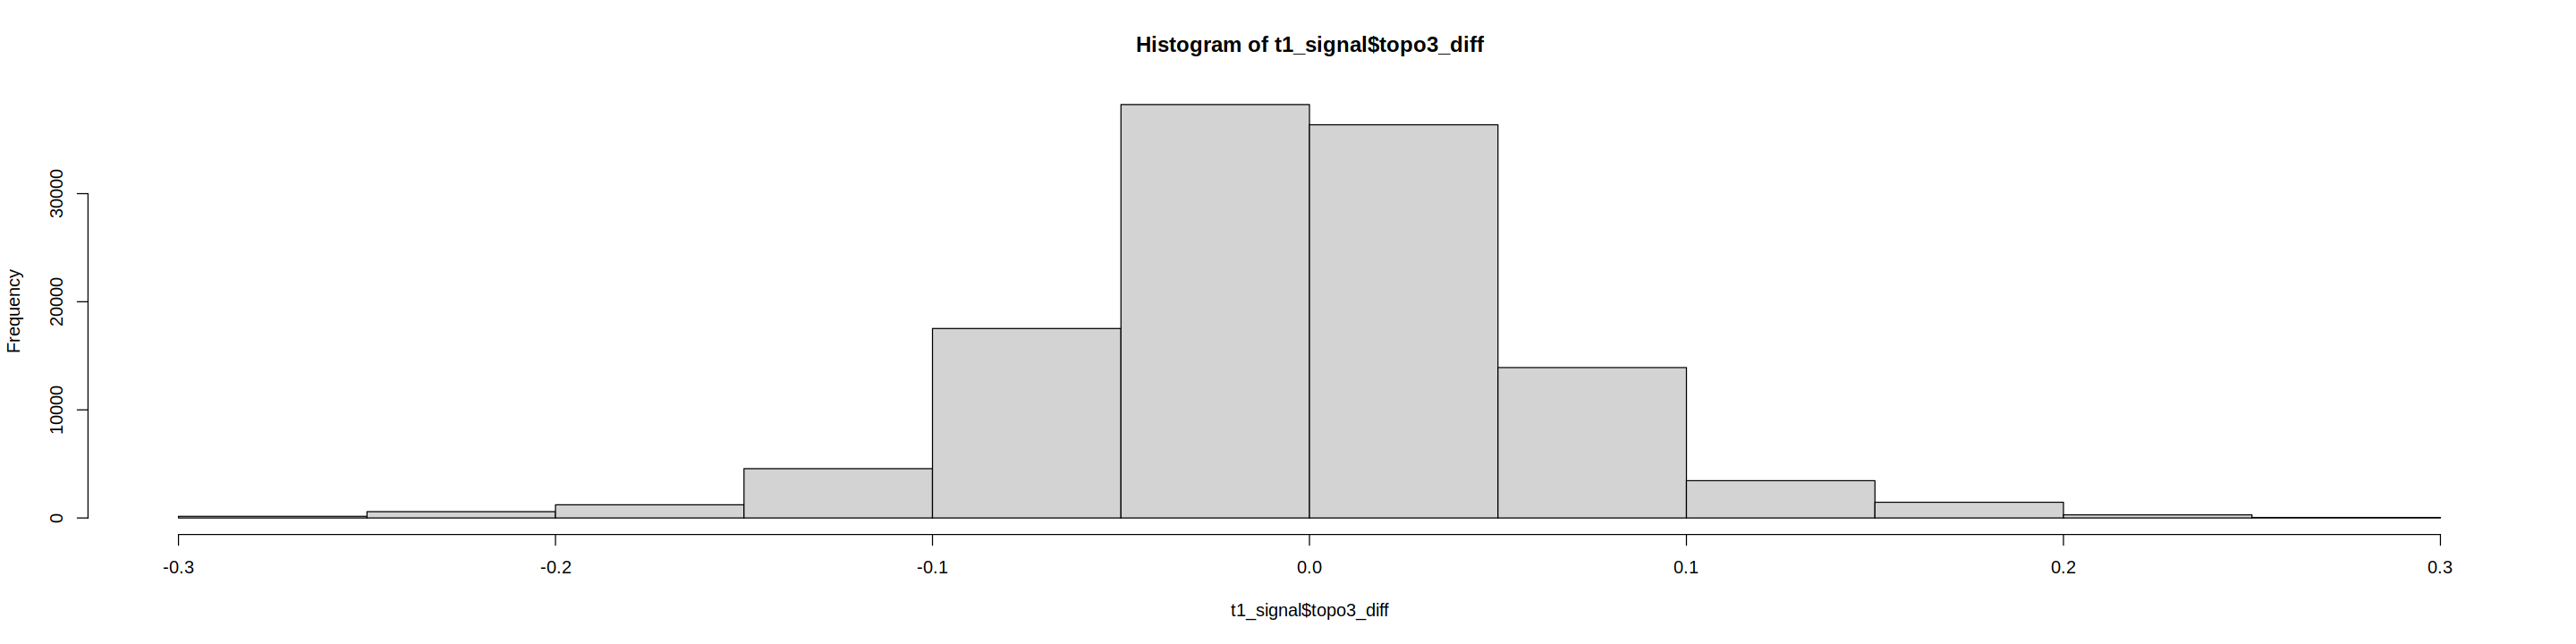

In [272]:
print(mean(t1_signal$topo3_diff))
print(median(t1_signal$topo3_diff))
print(std(t1_signal$topo3_diff))

hist(t1_signal$topo3_diff)

[1] -0.01286744
[1] -0.01001148
[1] 0.06691898


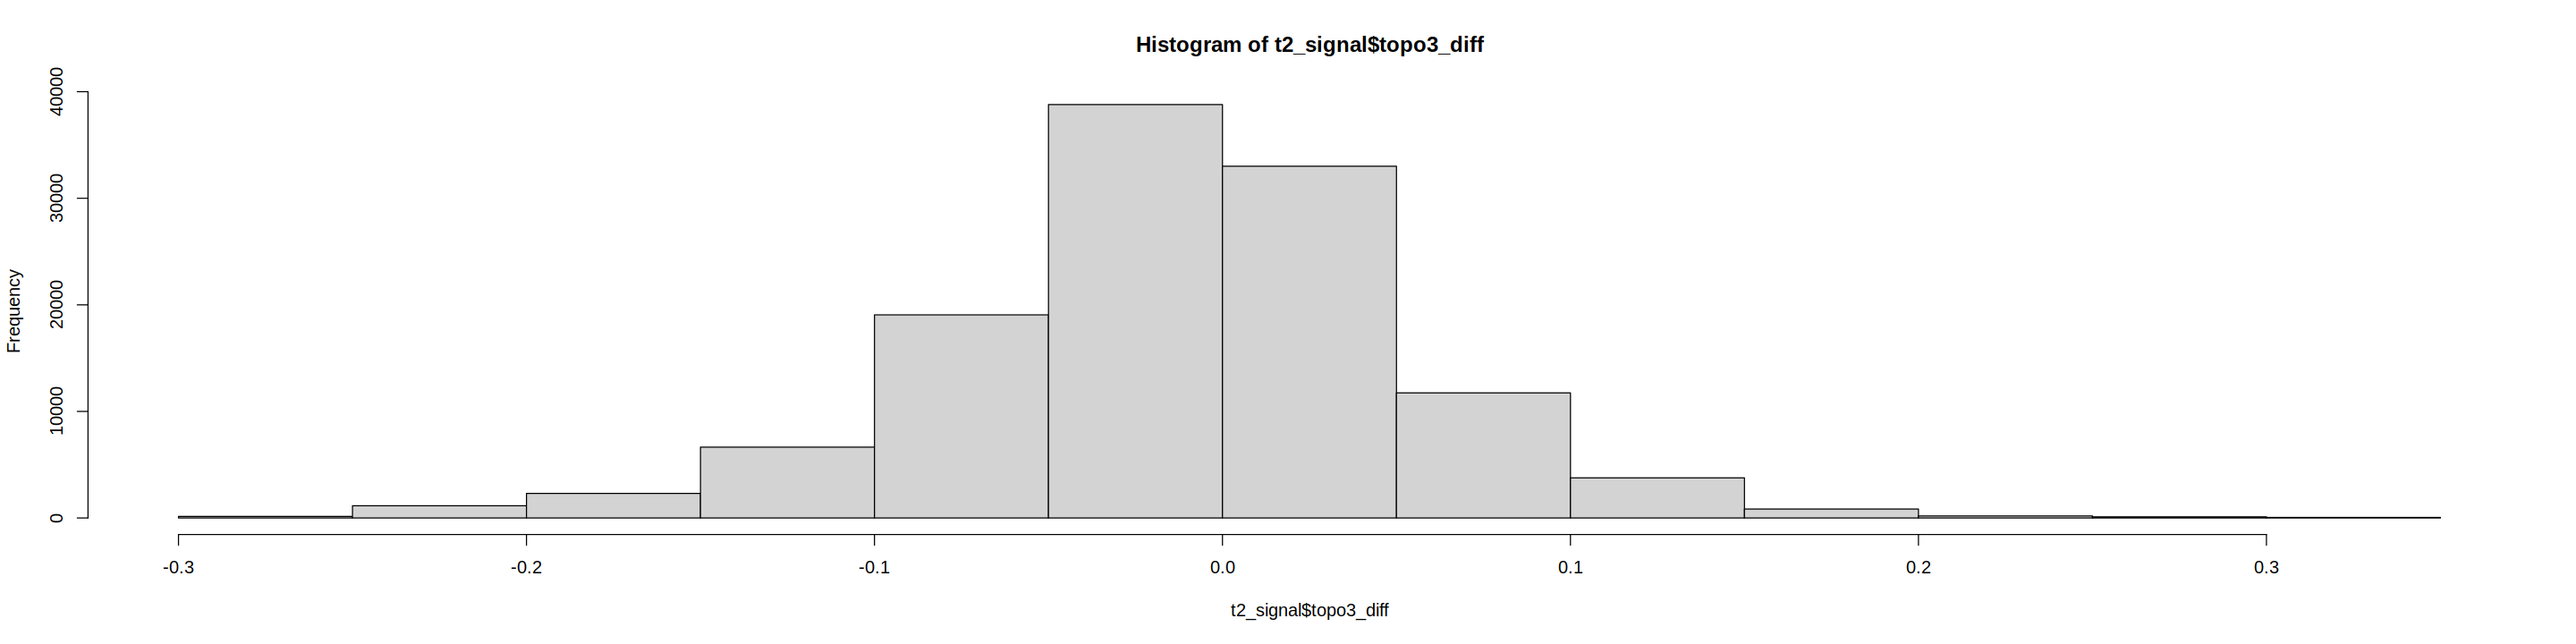

In [273]:
print(mean(t2_signal$topo3_diff))
print(median(t2_signal$topo3_diff))
print(std(t2_signal$topo3_diff))

hist(t2_signal$topo3_diff)

[1] 0.008607575
[1] 0.007393036
[1] 0.09180295


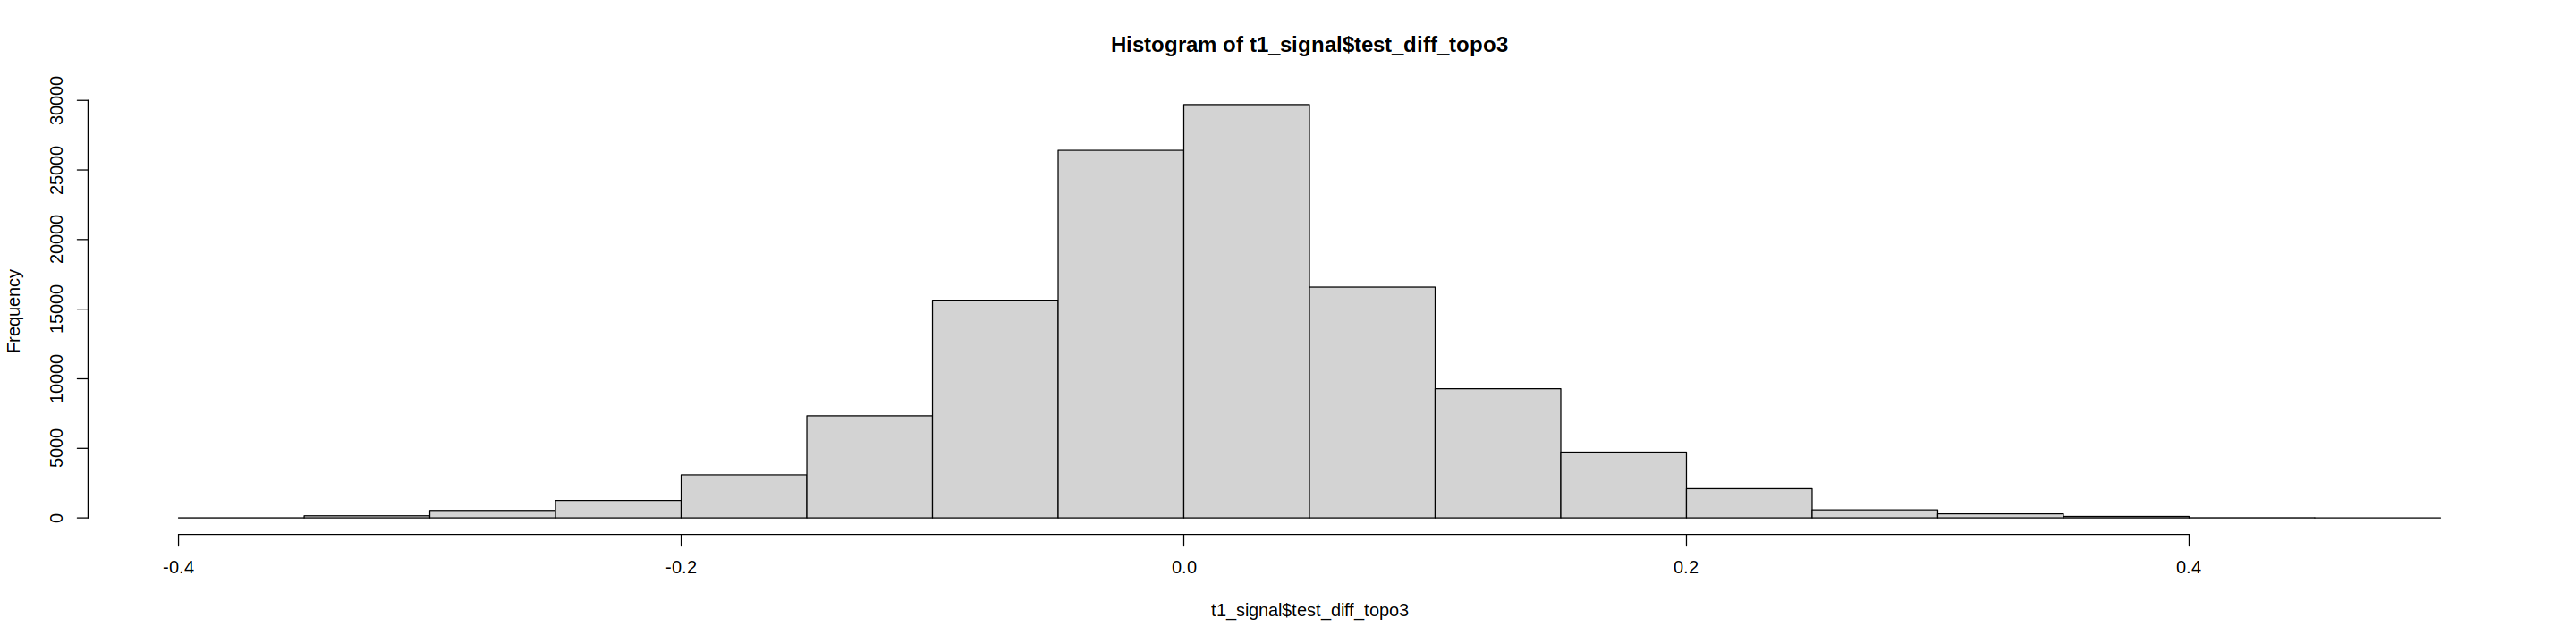

In [274]:
print(mean(t1_signal$test_diff_topo3))
print(median(t1_signal$test_diff_topo3))
print(std(t1_signal$test_diff_topo3))

hist(t1_signal$test_diff_topo3)

#### Subset the extreme values based on total percentage of weight
Extract the cases where the topo3 (discordant/introgression) topology makes up at least 30% of the weight. These will be cases that might indicate a strong signal of introgression. They are in the upper tail of the distribution of weights. 

In [275]:
t1_signal_sub <- subset(t1_signal, topo3 >= 0.3)

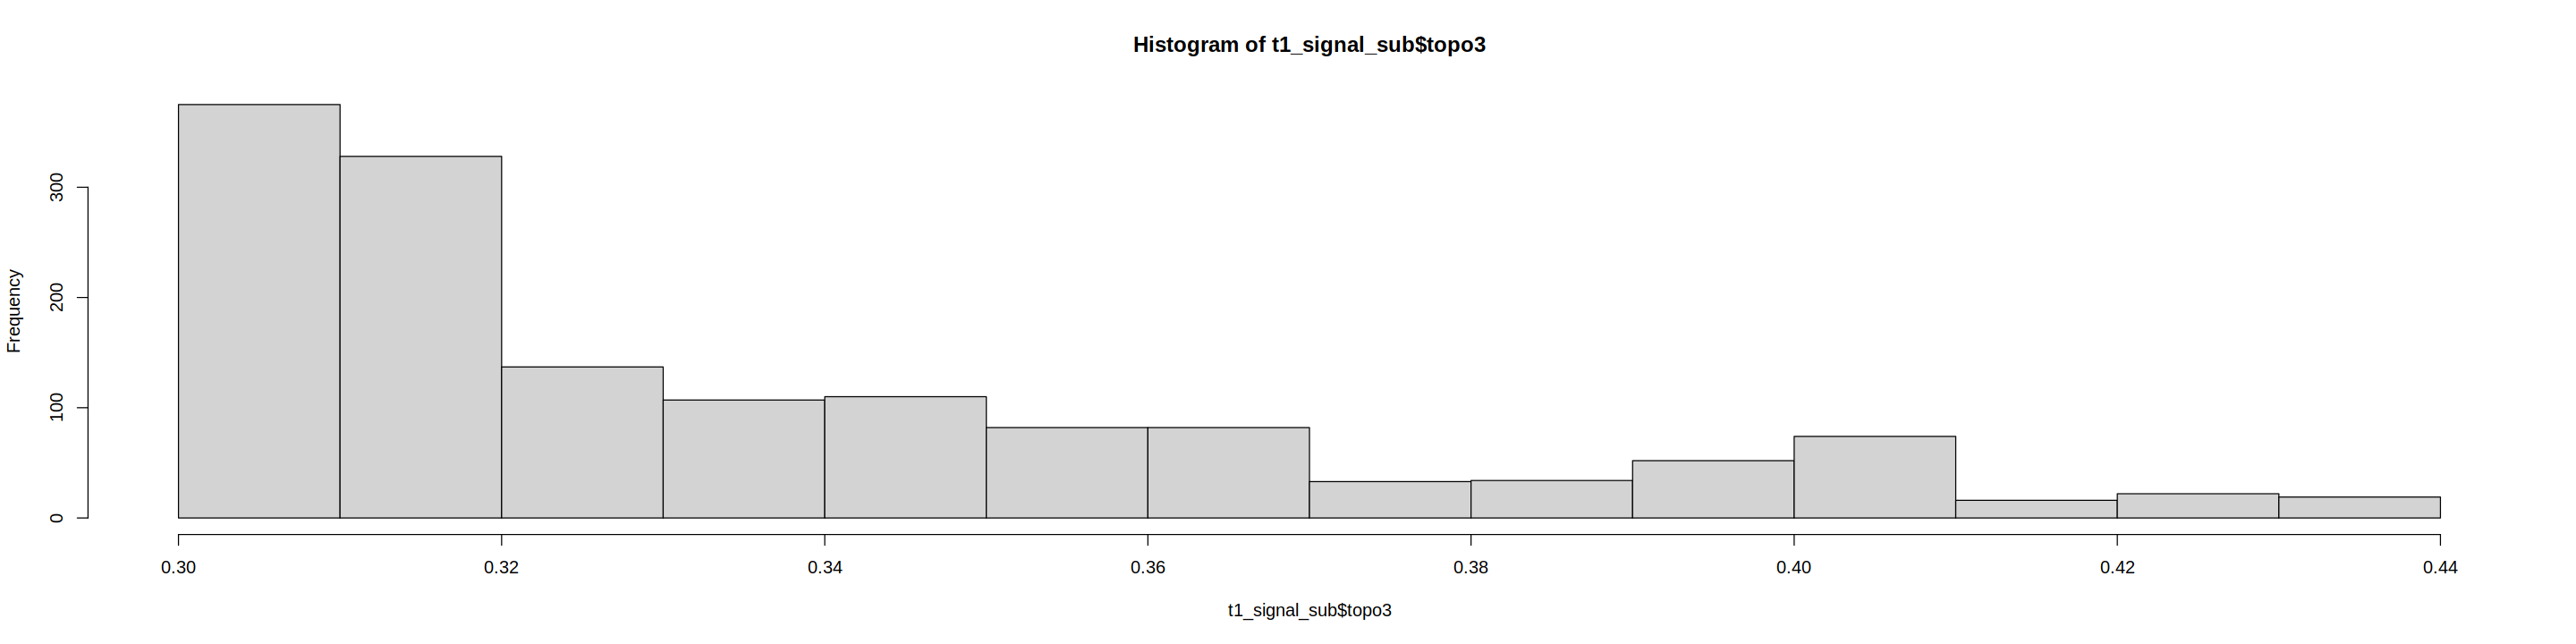

In [276]:
hist(t1_signal_sub$topo3)

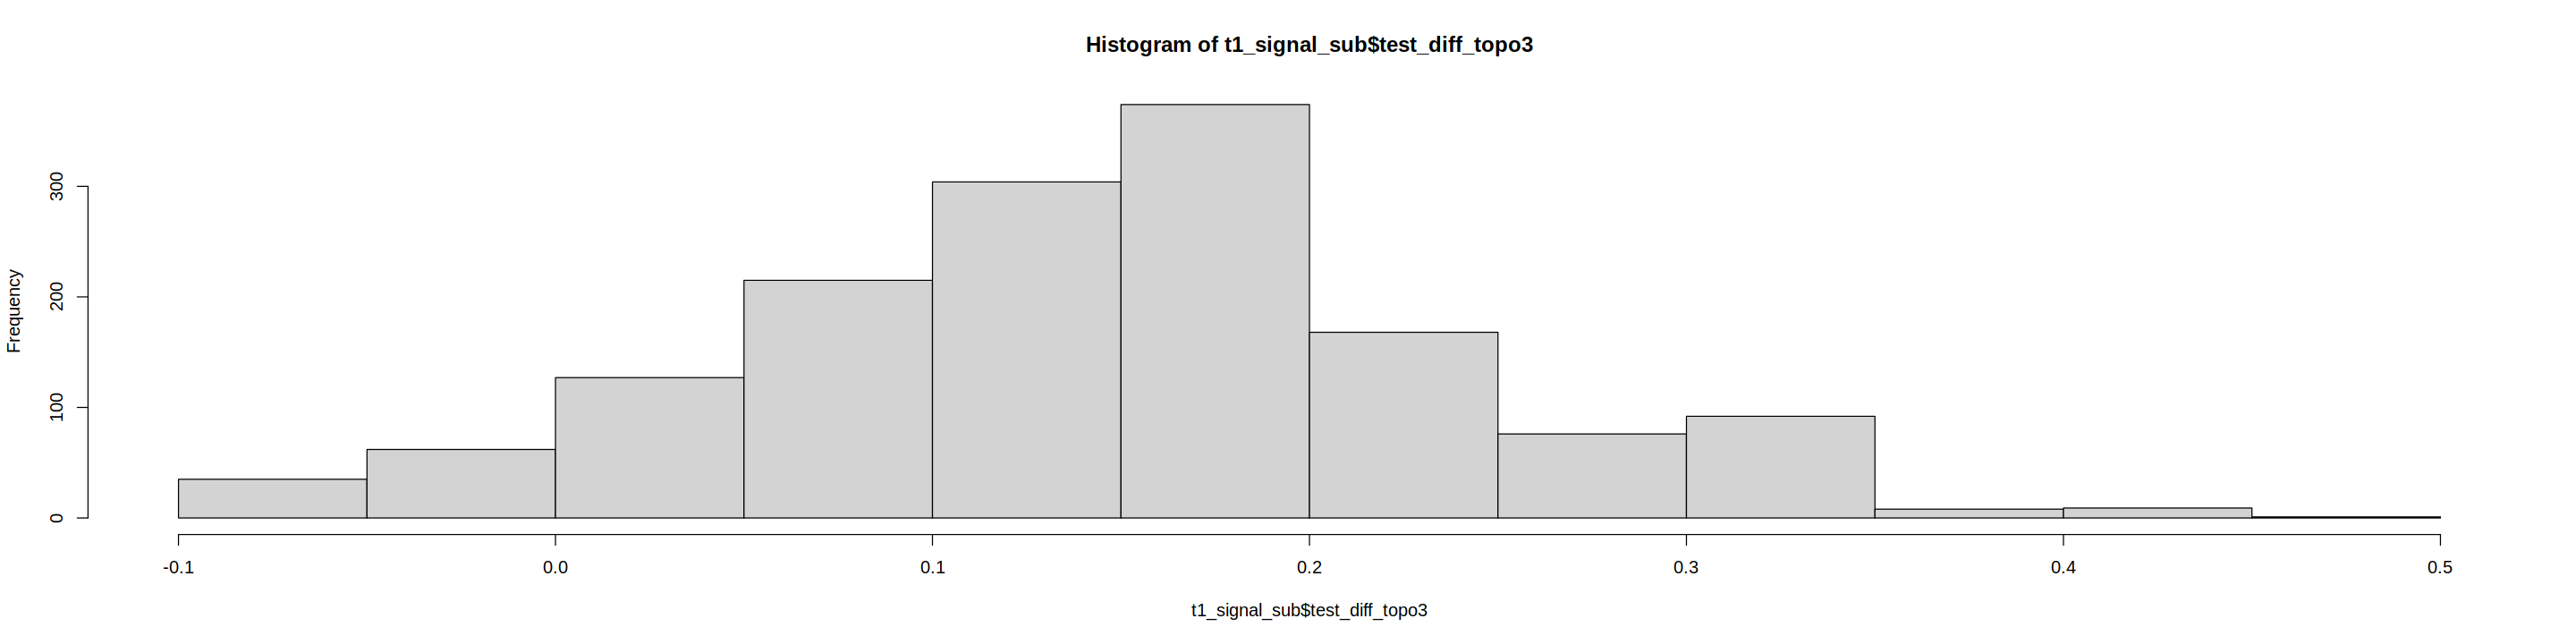

In [277]:
hist(t1_signal_sub$test_diff_topo3)

In [278]:
# Transform the difference of differences so that a higher value is indicative of similarity
t1_signal_sub["test_diff_topo3_inv"] = 1-t1_signal_sub["test_diff_topo3"]

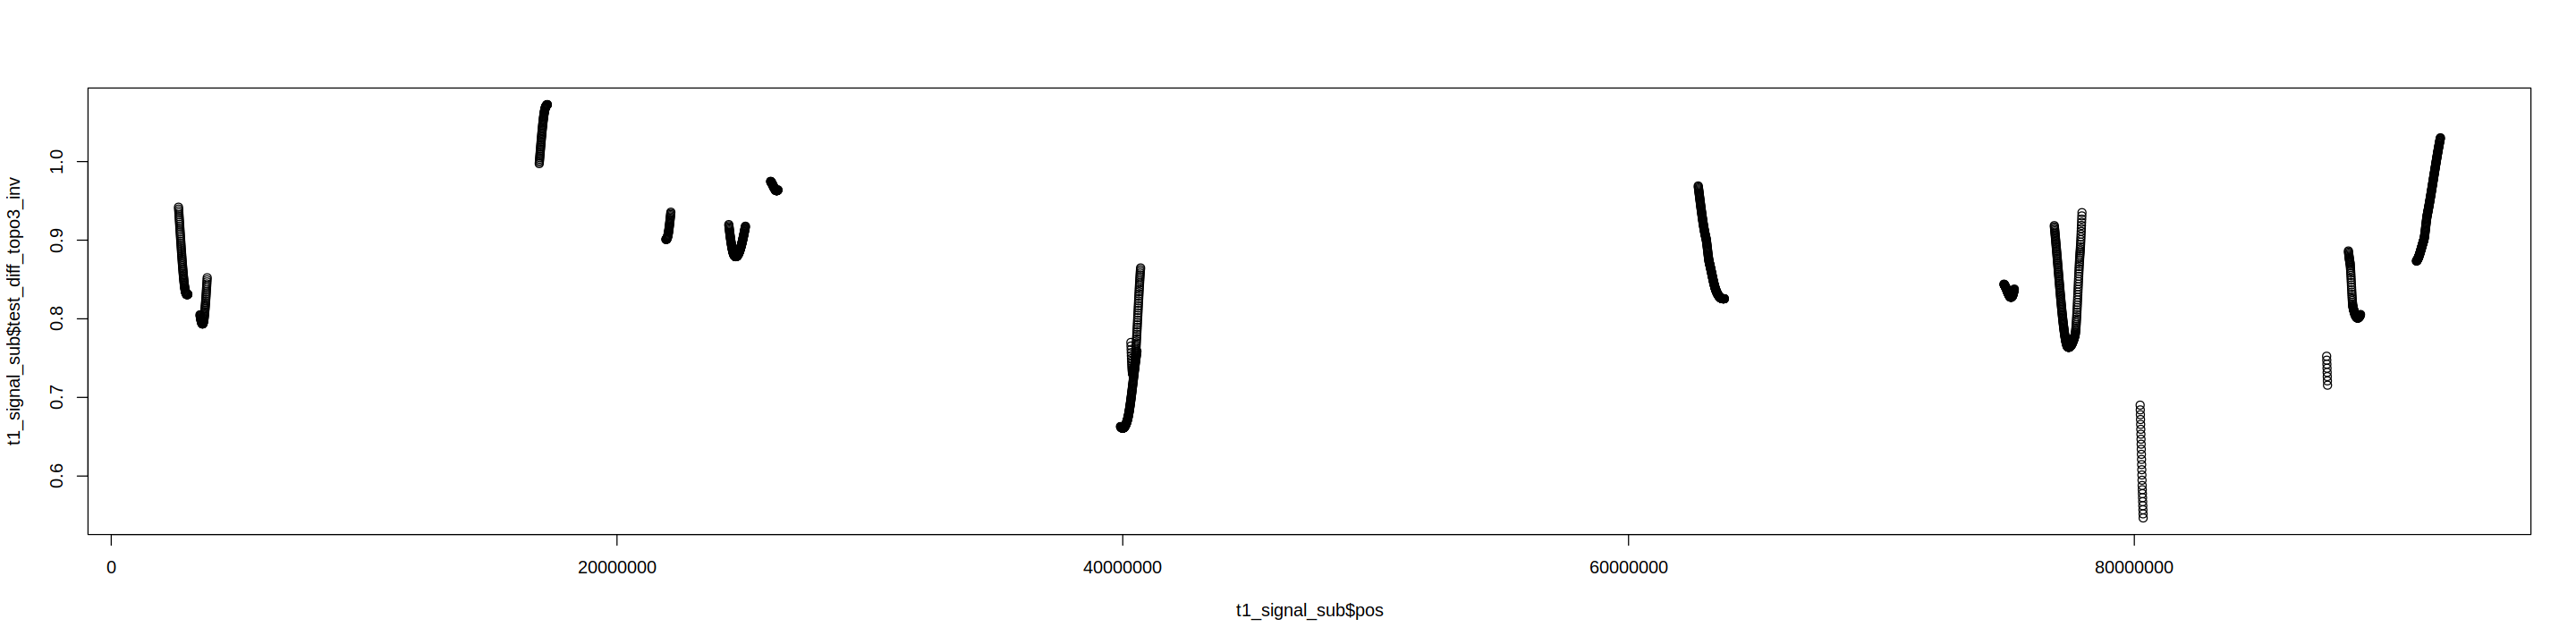

In [279]:
plot(t1_signal_sub$test_diff_topo3_inv ~ t1_signal_sub$pos)

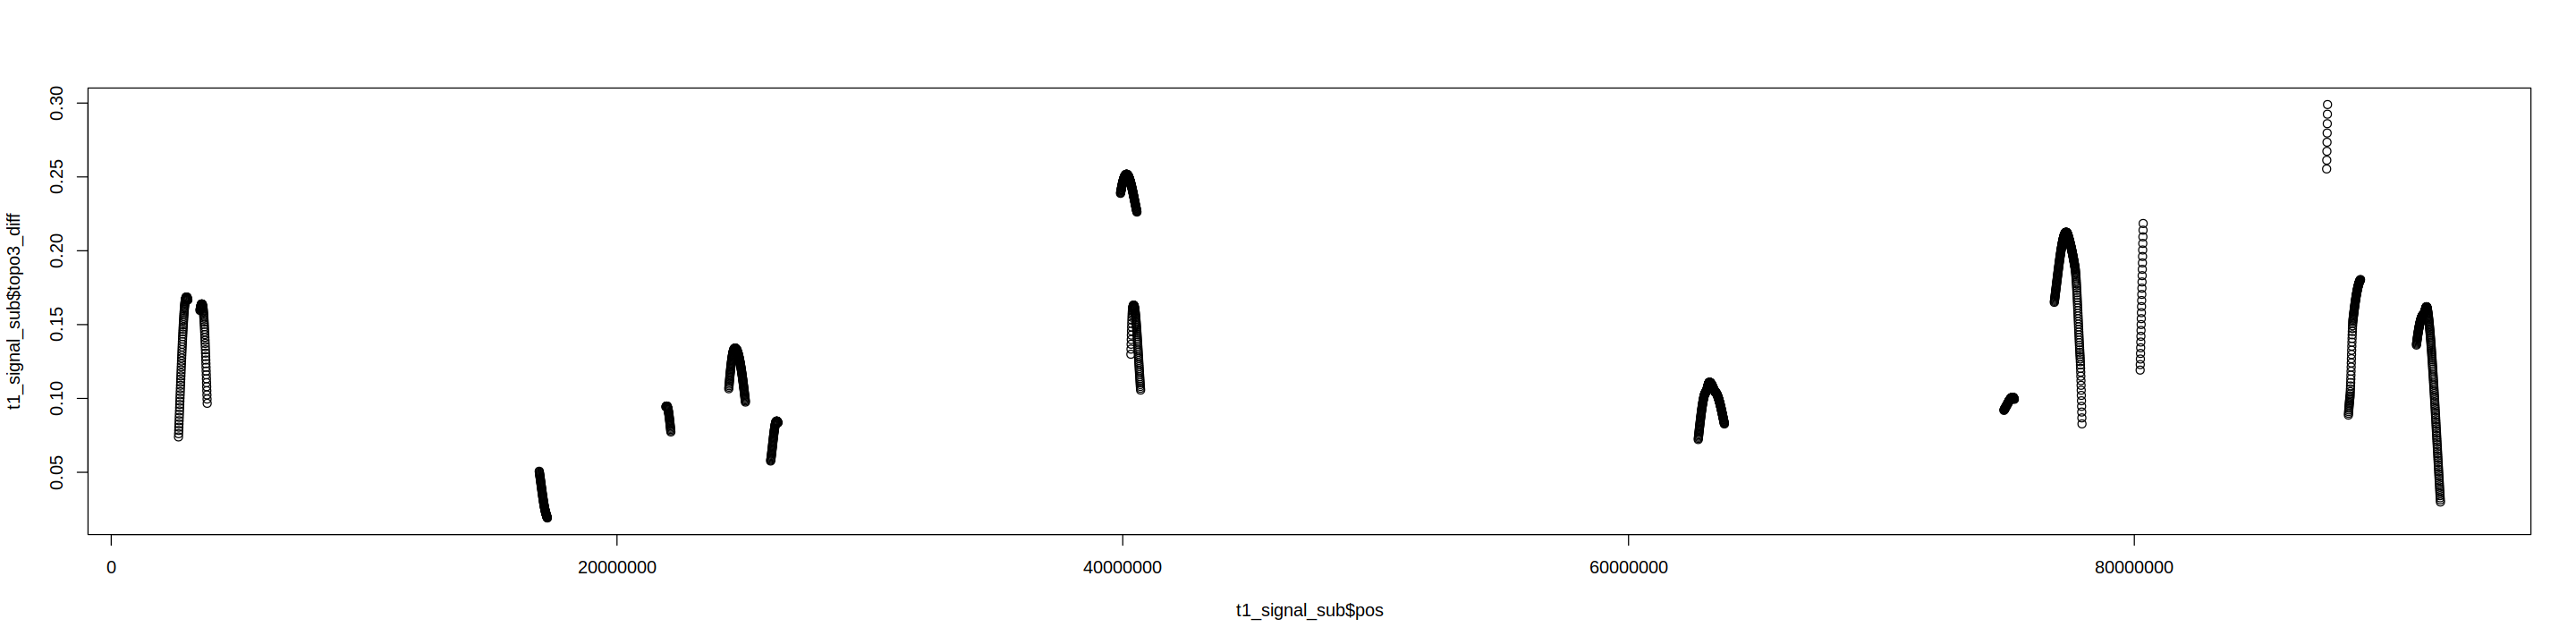

In [280]:
plot(t1_signal_sub$topo3_diff ~ t1_signal_sub$pos)

#### Use findpeaks to identify peaks in the dataset
Idenfity peaks in the transformed difference of differences, where a higher value indicates greater similarity between the two mirrored tests

In [281]:
peaks <- findpeaks(t1_signal_sub$test_diff_topo3_inv)

In [282]:
peaks

0.8440682,209,200,265
0.9185298,292,265,406
0.9350498,511,406,536
0.7523988,537,536,544
1.0725062,609,544,612
0.9355987,649,612,706
0.9177947,782,706,800
0.7698981,914,800,932
0.9748474,992,932,1040
0.9639326,1050,1040,1125
1.0302883,1338,1125,1408


In [283]:
t1_signal_sub[t1_signal_sub$test_diff_topo3_inv %in% peaks[,1],]

,pos,chromosome,testno,topo1,topo2,topo3,topo3_diff,test_diff_topo3,test_diff_topo3_inv
,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NA.11561,74845001,LG01,test1,0.4904772,0.2087847,0.3007381,0.09195332,0.15593182,0.8440682
NA.11959,76835001,LG01,test1,0.5632569,0.1358302,0.3009130,0.16508281,0.08147020,0.9185298
NA.12178,77930001,LG01,test1,0.4763585,0.2204332,0.3032083,0.08277506,0.06495019,0.9350498
NA.13715,87605001,LG03,test1,0.6546856,0.0449544,0.3003600,0.25540556,0.24760123,0.7523988
NA.30214,17245001,LG04,test1,0.4173845,0.2817789,0.3008366,0.01905765,-0.07250625,1.0725062
NA.127912,22130001,LG04,test1,0.4772875,0.2226885,0.3000241,0.07733559,0.06440129,0.9355987
NA.18693,25080001,LG04,test1,0.4973783,0.2025443,0.3000774,0.09753314,0.08220534,0.9177947
NA.56119,40320001,LG06,test1,0.5272501,0.1714027,0.3013472,0.12994447,0.23010187,0.7698981
NA.124316,26075001,LG07,test1,0.4574844,0.2424444,0.3000712,0.05762674,0.02515262,0.9748474


[1] 0.9121721
[1] 0.9267898
[1] 0.09741279


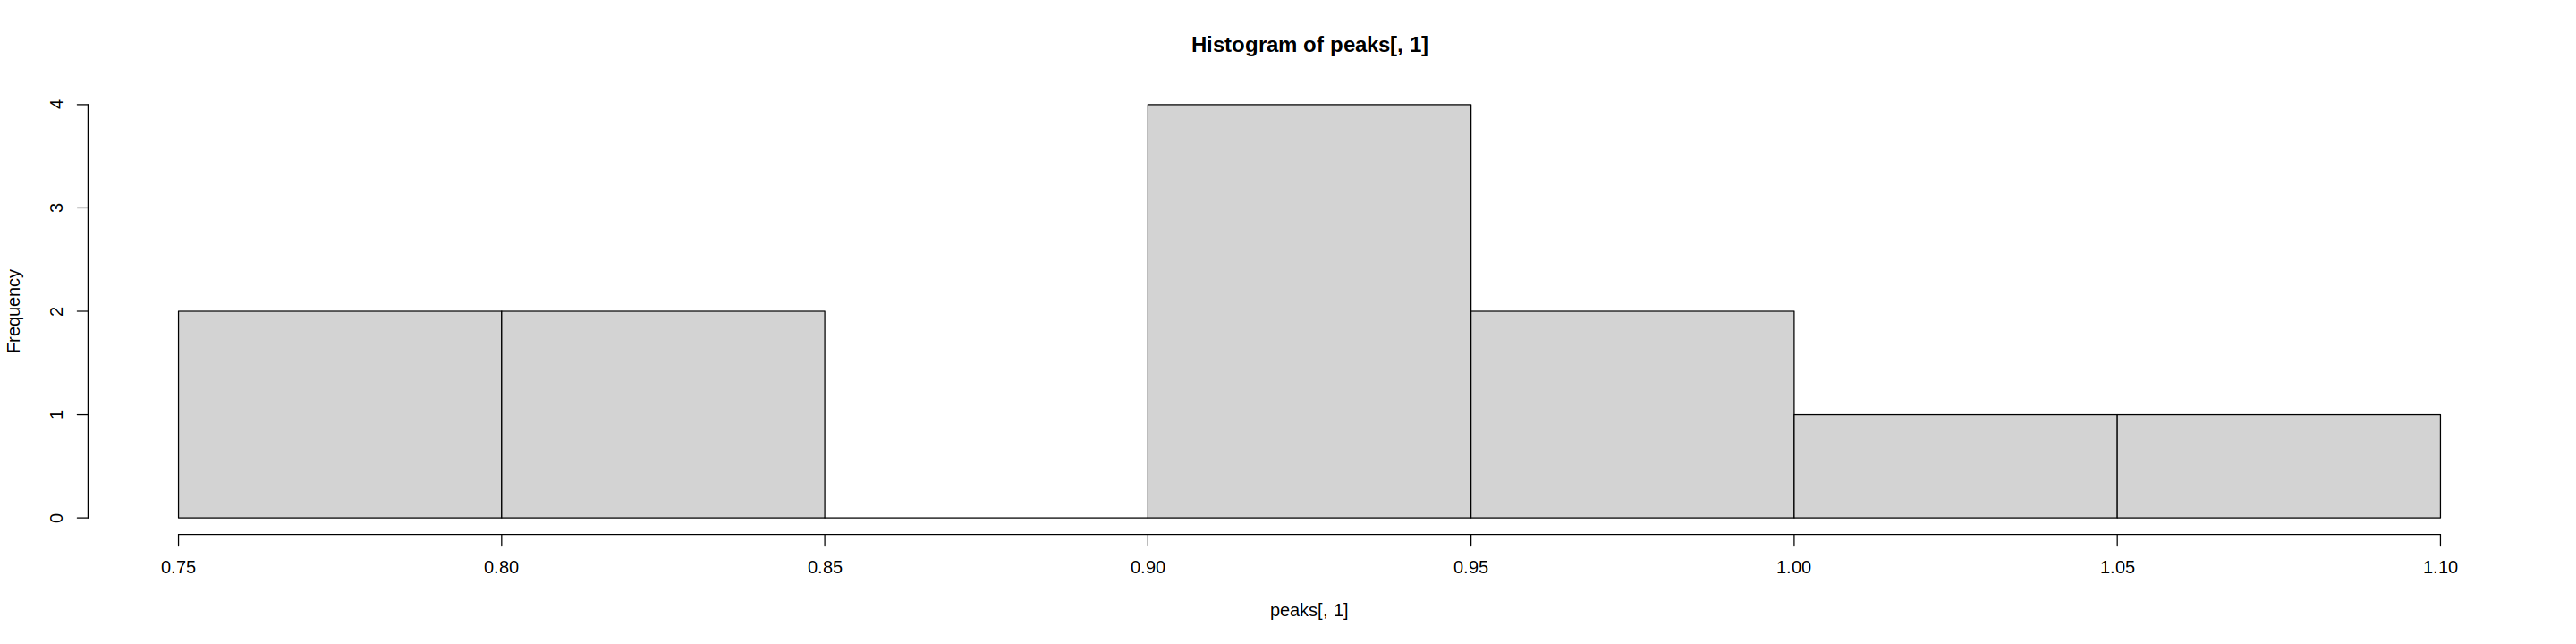

In [284]:
print(mean(peaks[,1]))
print(median(peaks[,1]))
print(std(peaks[,1]))

hist(peaks[,1])

### Examine distribution of topo weights of one across the topos/regions